<a href="https://colab.research.google.com/github/helliun/sent_similarity/blob/master/GPT4KG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Pip Installs
!pip install sentence-transformers -q
!pip install openai==0.26 -q
!pip install openai==0.27.1 -q
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 KB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
#@title Importing and Setting Up All Libraries
#@markdown Enter your OpenAI API key below
import json
import pydot
from sentence_transformers import SentenceTransformer, util
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import openai
from PIL import Image

openai.api_key = "" #@param {type: "string"}

In [32]:
#@title KnowledgeGraph Class
class KnowledgeGraph:
    def __init__(self,api_key,kg_file=""):
        openai.api_key = api_key 
        self.graph = pydot.Dot(graph_type="digraph")
        self.entities = {}
        self.fact_scores = {}
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = SentenceTransformer('all-MiniLM-L6-v2').to(self.device)
        self.entity_embeddings = {}
        if kg_file!="":
          self.load_graph(kg_file)

    def add_entity(self, name, description):
        if name not in self.entities:
            self.entities[name] = {"description": description}
            entity_node = pydot.Node(name, label=f"{name}\n({description})")
            self.graph.add_node(entity_node)
            self.entity_embeddings[name] = self.model.encode(name)#+": \n"+"\n".join([key+": "+kg.entities[name][key] for key in kg.entities[name]]))
            print("added embedding")
            
    def add_relationship(self, entity1, relationship, entity2):
        if entity1 in self.entities:
            try: 
              self.entities[entity1][relationship] += ", "+entity2
            except:
              self.entities[entity1][relationship] = entity2
            edge = pydot.Edge(entity1, entity2, label=relationship)
            self.graph.add_edge(edge)

    def update_graph(self, json_str,clean=True):
        try:
          data = json.loads(json_str)
        except:
          print("GPT4 failed to create a valid JSON. Input may be too long for processing.")
          return
        for entity_dict in data:
            for entity, relationships in entity_dict.items():
                try:
                  self.add_entity(entity, relationships[0]["description"])
                except:
                  self.add_entity(entity, "")
                for rel in relationships[1:]:
                    for relationship, other_entity in rel.items():
                        try:
                          self.add_relationship(entity, relationship, other_entity)
                        except:
                          for o in other_entity:
                            self.add_relationship(entity, relationship, o)
        if clean:
          for entity_dict in data:
              for entity, relationships in entity_dict.items():
                self.clean_graph(entity)

    def display_graph(self, output_file="knowledge_graph.png"):
        self.graph.write_png(output_file)
        img = Image.open(output_file)
        img.show()

    def search(self, query, n=5):
      if len(self.entity_embeddings)<5:
        n = len(self.entity_embeddings)
      query_embedding = self.model.encode(query)
      query_tensor = torch.tensor([query_embedding])
      entity_tensor = torch.tensor(list(self.entity_embeddings.values()))
      similarities = util.cos_sim(query_tensor, query_tensor).numpy()
      top_indices = np.argsort(similarities[0])[-n:][::-1]
      results = [(list(self.entity_embeddings.keys())[index], similarities[0][index]) for index in top_indices]
      return results

    def related_entities(self,query, n=5):
      query_embedding = self.model.encode(query)
      query_tensor = torch.tensor([query_embedding])
      potentities = [key+": "+self.entities[key]["description"] for key in self.entities]
      entity_tensor = self.model.encode(potentities)
      similarities = util.cos_sim(query_tensor, entity_tensor).numpy()
      if len(similarities)<n:
        n = len(similarities)
      top_indices = np.argsort(similarities[0])[-n:][::-1]
      results = [potentities[index] for index in top_indices]
      return results

    def text_to_data(self,text):
      system = {"role":"system","content":system_text}
      messages = [system]
      try:
        related = self.related_entities(text)
        text = text+f"\n\nGenerate the JSON for the text above, remembering to add inverse relationships and inferences. Here are some related entities already in the graph. If you are adding information about any of them, refer to them by the names below (otherwise ignore this information):\n\n{str(related)}"
      except:
        pass
      messages.append({"role":"user","content":text})
      output = openai.ChatCompletion.create(model="gpt-4",messages=messages)["choices"][0]["message"].to_dict()["content"]
      return output

    def learn(self,text,show_output=False):
      json_str = self.text_to_data(text)
      if show_output:
        print(json_str)
      self.update_graph(json_str)

    def graph_search(self,query,n=5,path="subgraph.png"):
      results = self.search(query, n)
      if len(results)<n:
        n = len(results)
      top_ents = [results[i][0] for i in range(n)]
      data = [{ent:[{key:self.entities[ent][key]} for key in self.entities[ent]]} for ent in top_ents]
      new = KnowledgeGraph()
      json_string = json.dumps(data) 
      new.update_graph(str(json_string),clean=False) 
      new.display_graph(path)
    
    def text_search(self,query,n=3):
      results = self.search(query, n)
      keys = [r[0] for r in results]
      potentities = [key+": "+str(self.entities[key]) for key in keys]
      for p in potentities:
        print(p)
    
    def qa_search(self,query,n=5):
      results = self.search(query, n)
      keys = [r[0] for r in results]
      facts = [key+": "+str(rel).replace("description","is")+" "+str(self.entities[key][rel]) for key in keys for rel in self.entities[key]]
      query_embedding = self.model.encode(query)
      query_tensor = torch.tensor([query_embedding])
      fact_tensor = self.model.encode(facts)
      similarities = util.cos_sim(query_tensor, fact_tensor).numpy()
      if len(similarities[0])<n:
        n = len(similarities)
      top_indices = np.argsort(similarities[0])[-n:][::-1]
      results = [facts[index] for index in top_indices]
      return results
    
    def chat_qa(self,query):
      results = self.qa_search(query)
      system = {"role":"system","content":"You are a helpful chatbot that answers questions based on data in your fact database."}
      messages = [system]
      text = f"Question: {query}\n\nFact Data: \n{results}"
      messages.append({"role":"user","content":text})
      output = openai.ChatCompletion.create(model="gpt-3.5-turbo",messages=messages)["choices"][0]["message"].to_dict()["content"]
      return output
    
    def clean_graph(self,key):
      facts = [key+": "+str(rel).replace("description","is")+" "+str(self.entities[key][rel]) for rel in self.entities[key]]
      rels = [rel for rel in self.entities[key]]
      fact_embs = self.model.encode(facts)
      scores = util.cos_sim(fact_embs,fact_embs)
      pairs = []
      for i in range(len(scores)):
        for j in range(len(scores[i])):
          if round(scores[i][j].item(),3)!=1.0 and scores[i][j]>0.7:
            if (facts[i],facts[j]) not in pairs and (facts[j],facts[i]) not in pairs:
              pairs.append((facts[i],facts[j]))
      for pair in pairs:
        system = {"role":"system","content":"You are a helpful chatbot that only outputs YES or NO"}
        messages = [system]
        messages.append({"role":"user","content":f"Do these two facts in our database express the same thing?: {pair}"})
        output = openai.ChatCompletion.create(model="gpt-4",messages=messages)["choices"][0]["message"].to_dict()["content"]
        if "yes" in output.lower():
          bad_index = facts.index(pair[1])
          redundant = rels[bad_index]
          del self.entities[key][redundant]
          good_index = facts.index(pair[0])
          validated = rels[bad_index]
          try:
            self.fact_scores[(key,validated)]+=1
          except:
            self.fact_scores[(key,validated)]=1

    def load_graph(self,kg_file):
      with open(kg_file) as f:
        lines = f.readlines()
        graph_data = "\n".join(lines[:-1])
        ents = eval(lines[-1])
      data = [{ent:[{key:ents[ent][key]} for key in ents[ent]]} for ent in ents]
      json_string = json.dumps(data)
      print(json_string)
      self.update_graph(str(json_string)) 
      self.graph = pydot.graph_from_dot_data(graph_data)[0]

    def save_graph(self,filename="mygraph.kg"):
      with open(filename,"w") as f:
        f.write("")
      self.graph.write_dot(filename)
      with open(filename,"a") as f:
        f.write("\n")
        f.write(str(self.entities))

In [4]:
#@title System Prompt
system_text = """You are an expert AI that extracts knowledge graphs from text and outputs JSON files with the extracted knowledge, and nothing more. Here's how the JSON is broken down.

Entity dictionaries are organized in a list
Every entity mentioned in the text has its own entity dictionary, in which the name of the entity is the key, and the value is a list of relationships.
Each relationship contains a short word or two accurately describing the relationship to the other entity as the key, and then the other entity as a value.
All inverses of these relationships are represented in the relationship list of the other entities. This is REALY IMPORTANT. For example if Apple created the iPhone, it is also important to note that the iPhone was created by Apple (each entity should have this relsationship from their perspective).
Non specified relationships are also inferred (if person X is the son of person Y, and person Z is person X's sibling, person Z is also the child of person Y).
The JSON contains NO NEW LINES. All the data should be on one line.

Every entity has a "description" relationship which provides a short description of what it is in a few words. If the description references another entity, then this relationship MUST be graphed, even if it is redundant.

Relationships are only created about facts, not just any connection between two entities mentioned in the text.


Example output:
[{"Toki Pona": [{"description": "philosophical artistic constructed language"}, {"translated as": "the language of good"}, {"created by": "Sonja Lang"}, {"first published": "2001"}, {"complete form published in": "Toki Pona: The Language of Good"}, {"supplementary dictionary": "Toki Pona Dictionary"}], "Sonja Lang": [{"description": "Canadian linguist and translator"}, {"creator of": "Toki Pona"}], "Toki Pona: The Language of Good": [{"description": "book"}, {"published in": "2014"}, {"language": "Toki Pona"}], "Toki Pona Dictionary": [{"description": "dictionary"}, {"released in": "July 2021"}, {"based on": "community usage"}]}]"""

In [ ]:
kg = KnowledgeGraph(openai.api_key)
#data = [{"GOOD Music": [{"description": "American independent record label"}, {"backronym": "Getting Out Our Dreams"}, {"founded by": "Kanye West"}, {"founded": "2004"}, {"signed agreement with": "Island Def Jam Music Group"}, {"debut compilation album": "Cruel Summer"}, {"previous president": "Pusha T"}, {"COO": "Steven Victor"}], "Kanye West": [{"description": "rapper"}, {"founder of": "GOOD Music"}], "Island Def Jam Music Group": [{"description": "record label group"}, {"signed agreement with": "GOOD Music"}], "Cruel Summer": [{"description": "debut compilation album"}, {"released by": "GOOD Music"}], "Pusha T": [{"description": "rapper"}, {"former president of": "GOOD Music"}, {"stepped down": "December 19, 2022"}], "Steven Victor": [{"description": "record executive"}, {"COO of": "GOOD Music"}]}]
#data = [{"GOOD Music": [{"description": "record label"}, {"released": "All of Me"}, {"released": "Panda"}, {"released": "Finding Forever"}, {"released": "Dark Sky Paradise"}, {"released": "I Decided"}, {"released": "Detroit 2"}, {"released": "The Life of Pablo"}, {"released": "Ye"}, {"released": "Jesus Is King"}, {"released": "Donda"}, {"released": "It's Almost Dry"}, {"no longer part of": "Def Jam Recordings"}, {"expired deal with": "Kanye West"}, {"released": "You Can't Kill Me"}], "John Legend": [{"description": "singer"}, {"sang": "All of Me"}], "All of Me": [{"description": "US Billboard Hot 100 single"}, {"singer": "John Legend"}, {"released by": "GOOD Music"}] ,"Desiigner": [{"description": "rapper"}, {"sang": "Panda"}], "Panda": [{"description": "US Billboard Hot 100 single"}, {"singer": "Desiigner"}, {"released by": "GOOD Music"}], "Common": [{"description": "rapper"}, {"album": "Finding Forever"}], "Finding Forever": [{"description": "US Billboard 200 album"}, {"rapper": "Common"}, {"released by": "GOOD Music"}] , "Big Sean": [{"description": "rapper"}, {"album": "Dark Sky Paradise"}, {"album": "I Decided"}, {"album": "Detroit 2"}], "Dark Sky Paradise": [{"description": "US Billboard 200 album"}, {"rapper": "Big Sean"}, {"released by": "GOOD Music"}], "I Decided": [{"description": "US Billboard 200 album"}, {"rapper": "Big Sean"}, {"released by": "GOOD Music"}]}]
data = [{"J.R.R. Tolkien": [{"description": "author"}, {"wrote": "The Lord of the Rings"}], "The Lord of the Rings": [{"description": "trilogy"}, {"author": "J.R.R. Tolkien"}, {"character": "Frodo Baggins"}, {"character": "Sauron"}, {"location": "Mount Doom"}, {"character": "Sam"}, {"character": "Merry"}, {"character": "Pippin"}, {"character": "Aragorn"}, {"character": "Legolas"}, {"character": "Gimli"}, {"character": "Saruman"}], "Frodo Baggins": [{"description": "hobbit protagonist"}, {"inherits": "ring"}, {"journey to": "Mount Doom"}], "ring": [{"description": "powerful and dangerous"}, {"created by": "Sauron"}], "Sauron": [{"description": "dark lord"}, {"creator of": "ring"}, {"defeated by": "destruction of ring"}], "Mount Doom": [{"description": "volcano"}, {"ring destroyed in": "fires"}], "Sam": [{"description": "hobbit"}, {"friend": "Frodo Baggins"}, {"journey to": "Mount Doom"}], "Merry": [{"description": "hobbit"}, {"friend": "Frodo Baggins"}], "Pippin": [{"description": "hobbit"}, {"friend": "Frodo Baggins"}], "Aragorn": [{"description": "human"}, {"friend": "Frodo Baggins"}], "Legolas": [{"description": "elf"}, {"friend": "Frodo Baggins"}], "Gimli": [{"description": "dwarf"}, {"friend": "Frodo Baggins"}], "Saruman": [{"description": "corrupted wizard"}, {"enemy of": "Frodo Baggins and company"}], "Middle-earth": [{"description": "fictional world"}, {"saved by": "destruction of ring"}]}]
#data = [{"Nibo": [{"description": "young penguin"}, {"lived in": "Antarctica"}, {"characteristics": ["restless spirit", "desire to explore"]}, {"known as": "most adventurous penguin in the colony"}, {"inspired": "fellow penguins"}], "Antarctica": [{"description": "icy continent"}, {"inhabited by": "penguins"}], "fellow penguins": [{"description": "Nibo's peers"}, {"viewed Nibo as": "strange"}, {"inspired by": "Nibo"}]}]
json_str = str(data).replace("'","\"")
kg.update_graph(json_str)

In [ ]:
kg = KnowledgeGraph(openai.api_key)

In [ ]:
kg.learn(input(),show_output=True)

Mike is a man
[{"Mike": [{"description": "man"}]}]


In [ ]:
kg.graph_search("Frodo",5)

In [ ]:
kg.save_graph()

In [ ]:
new = KnowledgeGraph("/content/mygraph.kg")

In [ ]:
kg.qa_search("What do other penguins think of nibo?")

In [ ]:
kg.chat_qa("What did nibo discover?")

In [ ]:
kg.entities["Harry"]

In [ ]:
new.display_graph()

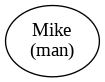

In [ ]:
kg.display_graph("temp.png")

In [ ]:
kg.fact_scores

In [ ]:
kg.entities["Frodo Baggins"]

In [40]:
import gradio as gr
from PIL import Image

def generate_graph(input_text,api_key):
  try:
    kg = KnowledgeGraph(api_key,"temp.kg")
  except:
    kg = KnowledgeGraph(api_key)
  kg.learn(str(input_text))
  kg.save_graph("temp.kg")
  kg.display_graph("temp.png")
  return Image.open("temp.png")

title = "GPT-4 Knowledge Graph Generator"
description = "Enter text to generate a knowledge graph using GPT4KG:"

with gr.Blocks() as demo:
  with open("temp.kg","w") as f:
    f.write("")
  gr.Markdown("""<h1><center>GPT-4 Knowledge Graph Generator</center></h1>""")
  output_image = gr.Image(label="Knowledge Graph", type="pil")
  api_key = gr.Textbox(lines=1, label="OpenAI API Key")
  input_text = gr.Textbox(lines=5, label="Information to be added to graph")
  submit_btn = gr.Button("Add info to graph")
  submit_btn.click(fn=generate_graph, inputs=[input_text,api_key], outputs=[output_image])

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a6a6875ecc16e13d9d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [45]:
kg = KnowledgeGraph(openai.api_key,"temp.kg")

[{"Moonwatcher": [{"description": "smart ape"}, {"knows how to": "use tools"}, {"learned from": "an alien"}, {"loves": "killing pigs, killing pigs"}]}, {"an alien": [{"description": "extraterrestrial being"}, {"taught": "Moonwatcher"}]}, {"tools": [{"description": "instruments used for tasks"}, {"used by": "Moonwatcher"}]}, {"killing pigs": [{"description": "activity"}, {"loved by": "Moonwatcher, Moonwatcher"}, {"liked by": "Moonwatcher"}]}]
added embedding
added embedding
added embedding
added embedding


In [30]:
kg.update_graph('''[{"Moonwatcher": [{"description": "smart ape"}, {"learns from": "Alien"}, {"learns to use": "tools"}, {"leader of": "Moonwatcher's tribe"}]}, {"Alien": [{"description": "extraterrestrial being"}, {"teaches": "Moonwatcher"}]}, {"tools": [{"description": "implements for killing"}]}, {"Moonwatcher's tribe": [{"description": "tribe"}, {"led by": "Moonwatcher"}]}]''')

In [42]:
kg.clean_graph("Moonwatcher")

In [43]:
kg.fact_scores

{}

In [46]:
kg.entities

{'Moonwatcher': {'description': 'smart ape',
  'knows how to': 'use tools',
  'learned from': 'an alien',
  'loves': 'killing pigs, killing pigs'},
 'an alien': {'description': 'extraterrestrial being',
  'taught': 'Moonwatcher'},
 'tools': {'description': 'instruments used for tasks',
  'used by': 'Moonwatcher'},
 'killing pigs': {'description': 'activity',
  'loved by': 'Moonwatcher, Moonwatcher',
  'liked by': 'Moonwatcher'}}